<a href="https://colab.research.google.com/github/DDani/saturdays.ai-stress/blob/PepToni/TeamStress_vFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Proyecto Team Stress***

# 1. Introducción

**Happyforce**

Happyforce es una plataforma de feedback para medir el compromiso (employee engagement) de los empleados permitiendo que empresas, managers y equipos puedan actuar, motivar y fidelizar el talento.

Al contrario que una encuesta de clima (que suelen ser anuales), Happyforce realiza una medición continua en dos formatos:

A través de una pregunta diaria de pulso, tan simple como preguntar al empleado cómo se encuentra (¿Cómo estás hoy?).
A través de preguntas sobre diferentes aspectos que afectan al engagement del empleado.

Dentro de esos aspectos, hay uno donde vamos a poner especial foco en este trabajo: el stress. Así, cada 3 meses, los empleados tienen la posibilidad de evaluar su nivel de stress con la siguiente pregunta: 

“¿En una escala del 1 al 10, ¿cómo calificarías el nivel de estrés en el trabajo?”

#2. Objetivo del estudio

El objetivo del estudio es determinar qué factores influyen en el estrés de un empleado. Para ello utilizaremos una de las preguntas incluidas en el Dataset "Scores": "**On a scale from 1 to 10, how would you rate the work-related stress?**". 

Vamos a definir cuándo consideramos que un empleado está estresado y cómo ha respondido con anterioridad a las preguntas planteadas por la aplicación.

#3. Tratamiento de datos

###3.1. Carga de librerias

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')

# creamos una función que nos permita ver más registros del dataset
def display_all(df):
    with pd.option_context("display.max_rows", 2000, "display.max_columns", 1000): 
        display(df)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###3.2. Cargamos los datos extraídos de la app HappyForce.
Por una parte tenemos un fichero con la puntuación del Hapyness Index y por otra parte tenemos las respuestas a las distintas preguntas que se realizan en la aplicación a lo largo de la semana.

In [2]:
scores = pd.read_csv('https://github.com/DDani/saturdays.ai-stress/blob/master/data/scores.zip?raw=true', compression='zip')
hi = pd.read_csv('https://github.com/DDani/saturdays.ai-stress/blob/master/data/hi.zip?raw=true', compression='zip')

Revisamos estructura de datos

In [3]:
scores.shape

(285512, 11)

In [4]:
scores.head()

,companyAlias,companyIndustry,scoreId,scoreName,factorId,factorName,questionId,questionTitle,employeeId,date,vote
0,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",qNd,20/09/2019,8
1,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",5gm,20/09/2019,8
2,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",QXd,20/09/2019,8
3,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",r6g,20/09/2019,10
4,5ad7d22a40bbc80004b73727,MANUFACTURING,5bfff05de6caa5000429c544,Employee Net Promoter Score (eNPS).,5bfff05de6caa5000429c542,eNPS,5bfff05de6caa5000429c543,"On a scale from 1 to 10, how likely are you to...",z82,20/09/2019,10


El dataset "scores" está estructurado de forma que cada registro representa la respuesta de un empleado a una pregunta determinada. Para cada registro tenemos las variables suficientes para identificar la compañia, el sector al que pertenece la compañia, el id de la pregunta, el id del factor al que se asocia la pregunta y la fecha en la que se responde a la pregunta, además de la puntuación asignada por el empleado (de 1 a 10).

In [5]:
hi.shape

(2364507, 5)

In [6]:
hi.head()

,companyAlias,companyIndustry,employeeId,date,vote
0,5ad7d22a40bbc80004b73727,MANUFACTURING,07,19/04/2018,1
1,5ad7d22a40bbc80004b73727,MANUFACTURING,kyQ,19/04/2018,3
2,5ad7d22a40bbc80004b73727,MANUFACTURING,y5w,19/04/2018,3
3,5ad7d22a40bbc80004b73727,MANUFACTURING,p1L,19/04/2018,3
4,5ad7d22a40bbc80004b73727,MANUFACTURING,bJ7,19/04/2018,3


sEl dataset "hi" contiene las respuestas al Happiness Index. Cada registro representa un voto de un empleado en una fecha determinada. Los valores del HI van del 1 al 4, siendo 4 la valoración más positiva.

###3.3. Construcción dataframe para modelizar

Para poder trabajar con las respuestas de cada empleado, necesitaremos crear un dataset en el que tengamos, para cada registro, toda la información relativa a un período anterior a la fecha en la que el empleado responde a la pregunta de estrés.

**Limpiamos el dataframe Scores**

Empezamos revisando si el dataset tiene duplicados.

In [7]:
scores.shape

(285512, 11)

In [8]:
scores.drop_duplicates(inplace = True);
scores.shape

(103330, 11)

Si comparamos con el "shape" antes y después de eliminar los duplicados, vemos como teníamos casi un tercio del dataset "scores" con registros duplicados

In [9]:
hi.shape

(2364507, 5)

In [10]:
hi.drop_duplicates(inplace = True);
hi.shape

(847935, 5)

Con el dataset "hi" nos ocurre lo mismo que con el anterior. En este caso, eliminando duplicados nos quedamos sólo con un tercio de la muestra.

Para que sea más cómodo trabajar con el dataframe, factorizamos el ID de las preguntas. De esta forma evitamos tener que tratar con el ID complejo que tienen asignados en el Dataset y trabajaremos con identificadores numéricos consecutivos. Esto nos facilitará la nomenclatura de las variables relativas a cada pregunta/factor.

In [11]:
scores['questionNumber'] = pd.factorize(scores['questionId'])[0]
scores['factorNumber'] = pd.factorize(scores['factorId'])[0]

Mostramos la codificación de preguntas y factores

In [12]:
pd.set_option('display.max_colwidth', -1)
questions=scores[['questionNumber','factorNumber','questionTitle','factorName']].drop_duplicates().reset_index(drop=True)
questions

,questionNumber,factorNumber,questionTitle,factorName
0,0,0,"On a scale from 1 to 10, how likely are you to recommend *|COMPANY_NAME|* as good place to work?",eNPS
1,1,1,"On a scale of 1 to 10, how comfortable do you feel giving upwards feedback to your manager?",Diversity of Opinion
2,2,1,I feel like I can voice my opinion regarding *|COMPANY_NAME|*:,Diversity of Opinion
3,3,1,"My teammates, welcome opinions different from their own.",Diversity of Opinion
4,4,2,*|COMPANY_NAME|* communicates in a clear and effective way us.,Quality & Frequency
5,5,2,My manager communicates openly and honestly with me.,Quality & Frequency
6,6,2,Which of the following best describes the amount of feedback you typically get regarding your work,Quality & Frequency
7,7,3,*|COMPANY_NAME|* seem to valuate my opinions and suggestions.,Active Listening
8,8,3,My manager embraces my opinions,Active Listening
9,9,3,"From 1 to 10, how would you rate how your co-workers and peers welcome your opinions?",Active Listening


**Variable Objetivo**

A continuación trataremos la variable objetivo para que sea el punto de partida del análisis. 

En el análisis sólo entrarán los empleados que hayan respondido a la pregunta de estrés. Preparamos un dataframe con estos empleados.

In [13]:
stressQuestionId = '5dd6e4a49a5137000450ff1d'
stressScores = scores[scores['questionId']==stressQuestionId]

In [14]:
stressScores.shape

(1885, 13)

En total tenemos 1885 votos en la pregunta de estrés

**Analisis la distribución de votos**

In [15]:
stressScores['vote'].value_counts().to_frame().style.bar()

,vote
3,495
4,401
2,251
1,197
5,188
6,149
7,82
8,68
9,34
10,20


In [16]:
stressScores['vote'].value_counts(sorted)

3     0.262599
4     0.212732
2     0.133156
1     0.104509
5     0.099735
6     0.079045
7     0.043501
8     0.036074
9     0.018037
10    0.010610
Name: vote, dtype: float64

In [17]:
print('Porcentaje malos: {:.2%}'.format(len(stressScores[stressScores['vote']<=3])/len(stressScores)))

Porcentaje malos: 50.03%


En la base de datos de Happy Force, se invirtió la puntuación de la pregunta para ir alineado con el resto de preguntas. De esta forma, una puntuación baja significa elevado nivel de estrés y viceversa. 

Si analizamos la distribución, vemos que tenemos un 50% de empleados que responden a la pregunta con puntuaciones inferiores o iguales a 3. Consideraremos estas puntuaciones para definir el estrés.

**Tratamiento fechas**

Cambiamos todas las variables que se refieren a fechas a un formato datetime para que Python las trate correctamente.

In [18]:
hi['date'] = pd.to_datetime(hi['date'])
stressScores['date'] = pd.to_datetime(stressScores['date'])
scores['date'] = pd.to_datetime(scores['date'])

**Creamos un diccionario de preguntas**

Para tratar correctamente todas las preguntas que tenemos en el dataset, vamos a crear diccionarios con cada una de las preguntas para tenerlas como datasets separados.

In [19]:
questionNumber = scores['questionNumber'].nunique()

df_questions = {}

for i in range(questionNumber):
  df_questions[i]  = scores[scores['questionNumber'] == i]

**Creamos un diccionario de factores**

Para los factores (grupos de preguntas), hacemos el mismo tratamiento que hemos hecho para las preguntas, agrupando en un diccionarios todos los valores para cada factor.

In [20]:
factorNumber = scores['factorId'].nunique()

df_factors = {}

for i in range(factorNumber):
  df_factors[i]  = scores[scores['factorNumber'] == i]

A continuación definimos la función que nos construirá el dataset que necesitamos para modelizar.

La función utiliza como base el dataset generado con las preguntas de estrés ("stressScores") y añade, para cada empleado un promedio de la ventana temporal (anterior a la respuesta de estrés) que le indiquemos en la misma función.

De esta forma podemos crear una variable para cada pregunta y/o factor que nos va a indicar el valor promedio de las respuestas del empleado en los meses anteriores que deseemos.

Hemos implementado la función de forma que si no se indica ninguna ventana ("window"), selecciona por defecto los "month" meses anteriores, mientras que si asignamos un valor a "window" nos calcula el promedio de hace "month" meses durante "window" mes. Esto nos permite anticiparnos al estrés utilizando variables que muestran qué puntuación tiene una pregunta 6 meses antes de que el empleado diga que está estresado. 

Por ejemplo, si llamamos a la función con los parámetros "month"=6 y "window"=1, la función nos calculará el promedio de todas las veces que un empleado contestó a una pregunta determinada entre 6 meses y 5 meses antes de la fecha en que respondió a la pregunta de estrés.

Este proceso se realiza para cada una de las preguntas y para cada vez que un empleado responde a la pregunta de estrés.

In [21]:
def build_stress_historic(df, stress_df, sfx, months, window=99):
  # Calculamos la fecha desde la cual queremos obtener la puntuación por empleado:
  stress_df['fromDate'] = pd.to_datetime(stressScores['date']) - pd.DateOffset(months=months)
  if window==99:
    stress_df['toDate'] = pd.to_datetime(stress_df['date'])
  else:
    stress_df['toDate'] = pd.to_datetime(stress_df['fromDate']) + pd.DateOffset(months=window)

  # Combinamos la pregunta con el dataframe de stress. Hacemos el merge a nivel empleado y le añadimos a la variable el número de 
  # meses y la ventana utilizada para el cálculo)
  stress_df_tmp = pd.merge(stress_df, df,on=['companyAlias', 'employeeId'], how='left', suffixes=('_stress',"_"+sfx + "_M" + str(months) + "_" + str(window)))

  #Añadimos le sufijo para la pregunta deseada
  date_  = "date_"+ sfx + "_M" + str(months) + "_" + str(window)
  vote_ = "vote_" + sfx +  "_M" + str(months) + "_" + str(window)

  # Nos quedamos con los registros, donde la fecha de respuesta este en la ventana de fecha de inicio y fin
  # fecha inicio: desde cuando queremos 'almacenar' la respuesta para un empleado;
  # fecha fin: cuando se registro el voto de la pregunta de stress
  stress_df_tmp = stress_df_tmp[(stress_df_tmp['toDate'] >= stress_df_tmp[date_]) & (stress_df_tmp[date_] >= stress_df_tmp['fromDate'])]

  # Nos quedamos con las columnas que nos interesan
  stress_df_tmp = stress_df_tmp[['employeeId', 'companyAlias', vote_, 'vote_stress', 'date_stress']]

  # Y calculamos el AVG de la pregunta para el periodo

  return stress_df_tmp.groupby(by=['employeeId', 'companyAlias', 'date_stress','vote_stress']).mean().reset_index() 
  
  # también está la opción de añadir el count para ver cuántas respuestas tenemos a cada pregunta. Una vez analizado lo hemos dejado comentado.
  #.agg(['count','mean'])


In [22]:
# Calculamos la fecha desde la cual queremos obtener la puntuación por empleado:
#months=6
#window=99
#stress_df=stressScores
#df=hi
#sfx='hi'

#stress_df['fromDate'] = pd.to_datetime(stressScores['date']) - pd.DateOffset(months=months)

#stress_df['toDate'] = pd.to_datetime(stress_df['date'])

  # Combinamos la pregunta con el dataframe de stress. Hacemos el merge a nivel empleado y le añadimos a la variable el número de 
  # meses y la ventana utilizada para el cálculo)
#stress_df_tmp = pd.merge(stress_df, df,on=['companyAlias', 'employeeId'], how='left', suffixes=('_stress',"_"+sfx + "_M" + str(months) + "_" + str(window)))

  #Añadimos le sufijo para la pregunta deseada
#date_  = "date_"+ sfx + "_M" + str(months) + "_" + str(window)
#vote_ = "vote_" + sfx +  "_M" + str(months) + "_" + str(window)

  # Nos quedamos con los registros, donde la fecha de respuesta este en la ventana de fecha de inicio y fin
  # fecha inicio: desde cuando queremos 'almacenar' la respuesta para un empleado;
  # fecha fin: cuando se registro el voto de la pregunta de stress
#stress_df_tmp = stress_df_tmp[(stress_df_tmp['toDate'] >= stress_df_tmp[date_]) & (stress_df_tmp[date_] >= stress_df_tmp['fromDate'])]


In [23]:
#stress_df_tmp;

**Juntamos todas las preguntas y sus valores en un dataframe completo**

Utilizamos la función creada para calcular promedios en ventanas temporales de tiempo para crear el dataset. Hemos elegido 1, 3 y 6 meses para crear nuestras variables y siempre con un período de observación de un mes.

In [24]:
months = [2,3,6]
base=stressScores.copy()
base['vote_stress']=stressScores['vote']
base['date_stress']=pd.to_datetime(stressScores['date'])
base=base[['companyAlias', 'employeeId', 'date_stress','vote_stress']]
#Primero preparamos la variable hi
big_df1 = build_stress_historic(hi, stressScores, 'hi', 6, 99)
big_df = pd.merge(base, big_df1, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')
small_df = build_stress_historic(hi, stressScores,  'hi', 3, 99)
big_df = pd.merge(big_df, small_df, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')
small_df = build_stress_historic(hi, stressScores,  'hi', 2, 99)
big_df = pd.merge(big_df, small_df, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')

#Añadimos las preguntas
for j in range(55):
  for i in months:
    small_df = build_stress_historic(df_questions[j], stressScores, str(j)+'_q', i, 99)
    big_df = pd.merge(big_df, small_df, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')

#Añadimos los factores
for j in range(len(df_factors)):
  for i in months:
    small_df = build_stress_historic(df_factors[j], stressScores, str(j)+'_f', i, 99)
    big_df = pd.merge(big_df, small_df, on = ['companyAlias', 'employeeId', 'date_stress','vote_stress'], how = 'left')


Añadimos el sector al dataframe

In [25]:
sector = scores[['companyIndustry', 'companyAlias']].drop_duplicates()
big_df = pd.merge(big_df, sector, on = ['companyAlias'], how = 'left')

In [26]:
df_nan=big_df.isna().sum().sort_values(ascending=False).to_frame().reset_index()
df_nan=df_nan.rename(columns={0:'num','index':'vars'})

In [27]:
#vars_good=df_nan[df_nan['num']<900]['vars'].to_list()
df_nan

,vars,num
0,vote_51_q_M2_99,1649
1,vote_13_q_M2_99,1648
2,vote_24_q_M2_99,1631
3,vote_22_q_M2_99,1631
4,vote_23_q_M2_99,1629
...,...,...
225,vote_21_q_M6_99,0
226,vote_7_f_M2_99,0
227,vote_7_f_M3_99,0
228,vote_7_f_M6_99,0


**Preparamos dataframe para modelizar**

Factorizamos las variables para obtener un dataframe con 0's y 1's en función de la puntuación de cada pregunta.

Tal y cómo hemos definido arriba, consideramos que las puntuaciones inferiores o iguales a 3 en la pregunta estrés nos indicarán que el empleado está estresado. Para el resto de preguntas, definimos respuesta negativa para puntuaciones inferiores o iguales a 5. Para el HI (al ir de 1 a 4) definimos 1 y 2 malo, 3 y 4 bueno.

In [28]:
df_cat = big_df.copy()

In [29]:
# para preguntas 'HI' asignamos '1' a las respuestas con valor 1 o 2
limite_hi=2
# para stress (variable objetivo) asignamos '1' a las respuestas con valor 1, 2 o 3
limite_stress=3
# para el resto de preguntas asignamos '1' para valores inferiores o iguales a 5.
limite_resto=5

var_dataset=df_cat.columns
for i in var_dataset:
  if i=='vote_stress':
    df_cat[i+'_cat']=df_cat[i].apply(lambda x: 1 if x<=limite_stress else 0)
  elif '_hi_' in i:
    df_cat[i+'_cat']=df_cat[i].apply(lambda x: 1 if x<=limite_hi else 0)
    df_cat.drop(i,inplace=True,axis=1)
  elif 'vote' in i and i !='vote_stress':
    df_cat[i+'_cat']=df_cat[i].apply(lambda x: 1 if x<=limite_resto else 0)
    df_cat.drop(i,inplace=True,axis=1)

Analizamos el estress en función del sector de la compañía.

In [30]:
resumen=df_cat[['companyIndustry','vote_stress_cat']].groupby(by=['companyIndustry']).agg(['count','sum']).reset_index()
resumen['% stress']=(resumen[('vote_stress_cat', 'sum')]/resumen[('vote_stress_cat', 'count')])*100
resumen.sort_values((       '% stress',      ''),ascending=False)

companyIndustry vote_stress_cat        % stress
                                                  count  sum           
9   NATURAL_RESOURCES                    39              29   74.358974
4   FINANCIAL_SERVICES_INSURANCE         334             210  62.874251
11  PUBLIC_AND_GOVERMENT_ADMINISTRATION  28              17   60.714286
13  WHOLESALE_AND_RETAIL_TRADE           33              19   57.575758
7   MANUFACTURING                        176             99   56.250000
3   EDUCATIONAL_SERVICES                 31              17   54.838710
5   HEALTH_CARE_SOCIAL_ASSISTANCE        293             152  51.877133
0   ACCOMMODATION_AND_FOOT_SERVICES      89              46   51.685393
1   ARTS_ENTERTAINMENT_RECREATION        4               2    50.000000
2   COMPUTER_SOFTWARE_IT_SERVICES        701             295  42.082739
10  NON_PROFIT_ORGANIZATION              102             41   40.196078
8   MARKETING_ADVERTISING                5               2    40.000000
12  UTILITIES_AND_SERVICES               15              6    40.000000
6   MANAGEMENT_CONSULTING                35              8    22.857143

En el análsis del estrés a nivel sector, vemos cómo el sector de NATURAL_RESOURCES es el que tiene un % de estrés más elevado, aunque el número de resuestas en la muestra no es muy elevado. Donde sí observamos un % de estrés elevado con una muestra robusta es en el sector FINANCIAL_SERVICES_INSURANCE. En general, tenemos % de estrés superiores al 40% en todos los sectores excepto en MANAGEMENT_CONSULTING. También destaca que COMPUTER_SOFTWARE_IT_SERVICES tiene uno de los % más bajos con un elevado número de respuestas.

A continuación, aplicamos 'get_dummies' a la variable 'companyIndustry' y añadimos el resultado al dataframe, eliminando las variables originales. De esta forma podremos relacionar el sector de la compañía con el estrés en la modelización.

In [31]:
df_dummies=pd.get_dummies(data=df_cat['companyIndustry'])
df_cat_dummies=pd.concat([df_cat,df_dummies],axis=1)
df_cat_dummies.drop(['companyAlias','companyIndustry'],inplace=True,axis=1)

Hacemos el mismo tratamiento para el mes de voto a la pregunta de stress. Estas variables nos permitirán ver si el mes del año influye en el estrés del empleado.

In [32]:
# seleccionamos el mes de voto
df_cat_dummies['month_stress']=pd.DatetimeIndex(df_cat_dummies['date_stress']).month
df_stress_info=df_cat_dummies[['employeeId','date_stress','vote_stress']]
df_cat_dummies.drop(['employeeId','date_stress','vote_stress'],inplace=True,axis=1)

# aplicamos get_dummies sobre la variable de mes de estres
df_dummies_month=pd.get_dummies(data=df_cat_dummies['month_stress'],prefix='month')
df_cat_dummies=pd.concat([df_cat_dummies,df_dummies_month],axis=1)
df_cat_dummies.drop(['month_stress'],inplace=True,axis=1)

Eliminamos del dataframe la pregunta 21 porque es la de estrés que utilizamos para la variable objetivo y, por tanto, duplicamos la columna. Además, eliminamos el factor 7 porque es el que incluye esta pregunta.

In [33]:
# eliminamos variables correspondientes a las preguntas de estres porque no nos aportan
# información a nuestro análisis
var_dataset=df_cat_dummies.columns
for i in var_dataset:
  if 'vote_7_f' in i or 'vote_21_q' in i:
    df_cat_dummies.drop(i,inplace=True,axis=1)

Verificamos que después de todo el tratamiento realizado, seguimos teniendo la misma proporción de estrés en la muestra.

In [34]:
print('Número total respuestas Stress dataframe original: {}'.format(len(stressScores)))
print('Proporción empleados estresados dataframe original: {:.2%}'.format(len(stressScores[stressScores['vote']<=limite_stress])/len(stressScores)))

Número total respuestas Stress dataframe original: 1885
Proporción empleados estresados dataframe original: 50.03%


In [35]:
print('Número total respuestas Stress dataframe categorizado: {}'.format(df_cat_dummies['vote_stress_cat'].count()))
print('Proporción empleados estresados dataframe categorizado: {:.2%}'.format(df_cat_dummies['vote_stress_cat'].sum()/df_cat_dummies['vote_stress_cat'].count()))

Número total respuestas Stress dataframe categorizado: 1885
Proporción empleados estresados dataframe categorizado: 50.03%


Vemos como, efectivamente, tenemos la misma proporción, por lo que nos permite afirmar que el tratamiento realizado hasta ahora es correcto.

A continuación calculamos la correlación entre la variable estrés y el resto de variables categorizadas.

In [36]:
df_cat_dummies_cor = df_cat_dummies.corr()
display_all(df_cat_dummies_cor.sort_values('vote_stress_cat',ascending=False)['vote_stress_cat'])

vote_stress_cat                        1.000000
vote_hi_M3_99_cat                      0.122525
FINANCIAL_SERVICES_INSURANCE           0.119240
vote_hi_M2_99_cat                      0.116943
vote_hi_M6_99_cat                      0.114630
vote_44_q_M6_99_cat                    0.099326
vote_4_q_M6_99_cat                     0.081239
vote_44_q_M3_99_cat                    0.080113
vote_16_q_M6_99_cat                    0.077355
vote_34_q_M6_99_cat                    0.076343
vote_12_f_M6_99_cat                    0.076343
NATURAL_RESOURCES                      0.070735
vote_0_q_M6_99_cat                     0.068632
vote_0_f_M6_99_cat                     0.068632
vote_16_q_M3_99_cat                    0.067303
month_1                                0.066491
vote_30_q_M6_99_cat                    0.066223
vote_4_q_M2_99_cat                     0.066101
vote_10_f_M6_99_cat                    0.064663
vote_44_q_M2_99_cat                    0.063896
vote_4_q_M3_99_cat                     0

Seleccionamos las variables con correlación superior al 6% o inferior al -6%.

In [37]:
df_best_corr=df_cat_dummies_cor[abs(df_cat_dummies_cor['vote_stress_cat'])>0.06]['vote_stress_cat']

In [38]:
df_best_corr.sort_values(ascending=False)

vote_stress_cat                  1.000000
vote_hi_M3_99_cat                0.122525
FINANCIAL_SERVICES_INSURANCE     0.119240
vote_hi_M2_99_cat                0.116943
vote_hi_M6_99_cat                0.114630
vote_44_q_M6_99_cat              0.099326
vote_4_q_M6_99_cat               0.081239
vote_44_q_M3_99_cat              0.080113
vote_16_q_M6_99_cat              0.077355
vote_12_f_M6_99_cat              0.076343
vote_34_q_M6_99_cat              0.076343
NATURAL_RESOURCES                0.070735
vote_0_q_M6_99_cat               0.068632
vote_0_f_M6_99_cat               0.068632
vote_16_q_M3_99_cat              0.067303
month_1                          0.066491
vote_30_q_M6_99_cat              0.066223
vote_4_q_M2_99_cat               0.066101
vote_10_f_M6_99_cat              0.064663
vote_44_q_M2_99_cat              0.063896
vote_4_q_M3_99_cat               0.063133
vote_43_q_M6_99_cat              0.062236
vote_3_q_M3_99_cat               0.061924
vote_16_q_M2_99_cat              0

Del análisis de correlación, vemos que las variables más correlacionadas con el estrés son el happiness index (en las distintas ventanas temporales incorporadas). Adicionalmente, entran también las siguientes preguntas:

44 - The business goals and strategies set by senior leadership are taking *|COMPANY_NAME|* in the right direction.

4 - *|COMPANY_NAME|* communicates in a clear and effective way us.

16 - I trust that the people I work with are committed to do a good job

34 - On a scale from 0-10, how would you rate the benefits *|COMPANY_NAME|* offers?

0 - On a scale from 1 to 10, how likely are you to recommend *|COMPANY_NAME|* as good place to work?

30 - I would rate the processes for determining pay in *|COMPANY_NAME|* as:

43 - I would rate the amount of resources, people and efforts that *|COMPANY_NAME|* invests to achieve its goals as:

3 - My teammates, welcome opinions different from their own.

26 - Do you have the tools and resources you need to do your job?

Junto con los factores:

12 - Benefits

0 - eNPS

10 - Compensation

Además, según la correlación resultante, los empleados de FINANCIAL_SERVICES_INSURANCE tienden a estar estresados, así como los del sector de NATURAL_RESOURCES (aunque no tanto). Por otra parte, tenemos que los empleados que trabajan en MANAGMENT_CONSULTING y COMPUTER_SOFTWARE_IT_SERVICES tienen correlación negativa, que indica que el comportamiento de estas variables es contrario al estrés. Por tanto, podríamos decir que los empleados de estos sectores tienen tendencia a estar menos estresados que los que trabajan en otros sectores.

La correlación de las variables de sector nos ratifican los resultados vistos en el análisis de estrés por sector.

También sale correlación negativa para la variable 'month_3' que está calculada a partir del mes de respuesta a la pregunta de estrés. Esto nos indica que el mes de marzo tiende a ser menos estresante (o lo empleados están dicen que están menos estresados).

Por último, tambien vemos correlación positiva para los empleados que responden a la pregunta de estrés en el mes de enero.

Comprobamos que no tenemos NaNs en el DataFrame

In [39]:
df_cat_dummies[df_cat_dummies['vote_stress_cat'] == 0].isna().sum().sort_values(ascending=False).max()

0

En el nuevo dataframe no tenemos ningún NaN.

Por último, vemos el total de respuestas negativas que tenemos para cada variable calculada (en total tenemos 1885 respuestas).

In [40]:
len(df_cat_dummies)

1885

Creamos una lista sólo de variables relacionadas con el voto para que las otras variables categóricas no nos distorsionen el análisis.

In [41]:
var_votes=list()
for i in df_cat_dummies.columns:
  if 'vote' in i:
    var_votes.append(i)

In [42]:
display_all(df_cat_dummies[var_votes].sum().sort_values(ascending=False))

vote_stress_cat        943
vote_40_q_M6_99_cat    823
vote_46_q_M6_99_cat    754
vote_26_q_M6_99_cat    741
vote_10_q_M6_99_cat    722
vote_32_q_M6_99_cat    713
vote_42_q_M6_99_cat    697
vote_12_q_M6_99_cat    694
vote_36_q_M6_99_cat    693
vote_40_q_M3_99_cat    689
vote_14_f_M6_99_cat    686
vote_46_q_M3_99_cat    681
vote_6_q_M6_99_cat     648
vote_42_q_M3_99_cat    604
vote_14_f_M3_99_cat    604
vote_10_q_M3_99_cat    601
vote_39_q_M6_99_cat    598
vote_49_q_M6_99_cat    598
vote_46_q_M2_99_cat    597
vote_26_q_M3_99_cat    593
vote_19_q_M6_99_cat    590
vote_12_q_M3_99_cat    589
vote_40_q_M2_99_cat    582
vote_32_q_M3_99_cat    579
vote_31_q_M6_99_cat    567
vote_36_q_M3_99_cat    563
vote_19_q_M3_99_cat    545
vote_14_f_M2_99_cat    535
vote_11_f_M6_99_cat    535
vote_26_q_M2_99_cat    534
vote_23_q_M6_99_cat    527
vote_6_q_M3_99_cat     524
vote_3_q_M6_99_cat     523
vote_52_q_M6_99_cat    522
vote_10_q_M2_99_cat    507
vote_39_q_M3_99_cat    494
vote_12_q_M2_99_cat    486
v

Vemos como hay algunas preguntas que tienen muchos votos negativos. Las más destacadas son:


40 - At work, I know what I’m expected to deliver

46 - I'm involved in decisions that affect my work

26 - Do you have the tools and resources you need to do your job?

10 - What is it like working with your direct manager?

32 - For *|COMPANY_NAME|* to celebrate our accomplishments and milestones is:

42 - The vision and purpose of *|COMPANY_NAME|* inspires me.

12 - When I ask my manager for help, he/she devotes time to help me

36 - Our organizational values are reflected in every decision taken at *|COMPANY_NAME|*	

6 - Which of the following best describes the amount of feedback you typically get regarding your work


# 4. Modelización

## 4.1. Árbol de decisión

Empezamos la modelización con el método más sencillo. 

Para empezar definimos las librerías necesarias.

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split

A continuación necesitamos separar la variable objetivo del dataframe.

In [44]:
y=df_cat_dummies.pop('vote_stress_cat')
X = df_cat_dummies

Dividimos la muestra en train y test con la función 'train_test_split'.

In [45]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2,random_state=17)

Aplicamos el 'DesicionTreeClassifier' con un 'GridSearchCV' para probar diferentes hiperparámetros que nos permitan encontrar el árbol que más se ajuste a nuestros datos. Los hiperparámetros que modificamos en el 'GridSearchCV' son la profundidad ('max_depth') y el número máximo de variables ('max_features').

In [46]:
# aplicamos modelo
clf_tree=DecisionTreeClassifier(criterion='entropy', random_state=17)

tree_params = {'max_depth': range(1,15),
               'max_features': range(4,28)}

#aplicamos cros validation con los parametros definidos y le indicamos que nos saque los score de entrenamiento
tree_grid = GridSearchCV(clf_tree, tree_params,cv=5, n_jobs=-1,verbose=True,return_train_score=True)

# Entrenar el clasificador con el dataset de train
tree_grid.fit(X_train, y_train)

predicted = tree_grid.best_estimator_.predict(X_test)
print('La precisión que tenemos con el mejor árbol de decisión de la red es: {0:.4f}'.format(accuracy_score(y_test, predicted)))

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    4.0s


La precisión que tenemos con el mejor árbol de decisión de la red es: 0.5782


[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:   15.5s finished


In [47]:
print('La precisión que tenemos con el mejor árbol de decisión de la red es: {0:.4f}'.format(accuracy_score(y_test, predicted)))

La precisión que tenemos con el mejor árbol de decisión de la red es: 0.5782


Hiperparámetros del mejor árbol de decisión encontrado:

In [48]:
tree_grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=19, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

Creamos una clasificación con las 10 mejores combinaciones.

In [49]:
train_score=tree_grid.cv_results_['mean_train_score']
test_score=tree_grid.cv_results_['mean_test_score']
rank=tree_grid.cv_results_['rank_test_score']
params=tree_grid.cv_results_['params']

#seleccionamos el top10 de scores
rank10=rank[rank<11]
train_score10=train_score[rank<11]
test_score10=test_score[rank<11]

#creamos dataframe
datos=pd.DataFrame({'rank': np.array(rank, dtype='int32'),
                 'mean_train_score': np.array(train_score, dtype='float32'),
                 'mean_test_score': np.array(test_score, dtype='float32')})
datos1=pd.DataFrame(params)
resultados=datos.merge(datos1, left_index=True, right_index=True)
resultados=resultados.sort_values(by='rank',ascending=True,ignore_index=True)
resultados.head(10)

,rank,mean_train_score,mean_test_score,max_depth,max_features
0,1,0.570293,0.570313,2,19
1,2,0.576261,0.568971,3,26
2,3,0.744196,0.566331,14,18
3,4,0.564324,0.564333,2,5
4,5,0.589688,0.564324,4,24
5,6,0.662135,0.564307,8,23
6,7,0.637102,0.563666,7,24
7,8,0.593005,0.563658,4,26
8,9,0.570790,0.563006,2,21
9,10,0.575101,0.562998,3,23


Dibujamos el mejor árbol de decisión.

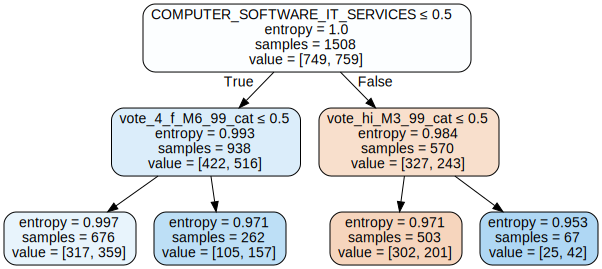

In [50]:
!pip install graphviz

from sklearn.tree import export_graphviz
import graphviz 

dot_data = export_graphviz(tree_grid.best_estimator_, out_file=None) 
graph = graphviz.Source(dot_data) 
dot_data = export_graphviz(tree_grid.best_estimator_, out_file=None, 
                      feature_names=X_train.columns,
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

## 4.2. Random Forest

Una vez vemos que el árbol de decisión puede ser un buen método para predecir el estrés sobre los empleados de nuestra muestra, vamos a ver si el Random Forest nos mejora esta predicción.

Para empezar definimos las librerías necesarias.

In [51]:
from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def rmse(x,y):return np.sqrt(((x-y)**2).mean())

Dividimos la muestra en train y test.

In [52]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size =0.2,random_state=17)

Aplicamos método 'RandomForestClassifier' y calculamos los rmse y scores asociados a la predicción.

In [53]:
RF=RandomForestClassifier(n_estimators=200,max_leaf_nodes=50,min_samples_leaf=20,
                         min_samples_split=20,max_depth=70,max_features=0.9,
                         n_jobs=-1,random_state=17)
RF.fit(X_train,y_train)
pred=RF.predict(X_train)
pred1=RF.predict(X_test)
print('RMSE Train: {0:.4f}'.format(rmse(pred,y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(pred1,y_test)))
print('Precisión Train: {0:.4f}'.format(RF.score(X_train,y_train)))
print('Precisión Test: {0:.4f}'.format(RF.score(X_test,y_test)))

RMSE Train: 0.5529
RMSE Test: 0.6371
Precisión Train: 0.6943
Precisión Test: 0.5942


Una vez hemos ajustado manualmente nuestro Random Forest, vamos a construir un GridSearch para ver si encontramos un modelo más preciso. Para limitar el tiempo de ejecución, vamos a utilizar el RandomizedSearchCV que nos permitirá realizar un número determinado de combinaciones sobre todos los parámetros que le indiquemos.

In [54]:
parameters={'max_depth': [50,70,90,110,130,150,200,250,300,500],
 'max_features': ['log2','sqrt',0.5,0.3,0.7],
 'n_estimators': [130,200,350,500],
 'max_leaf_nodes': [int(x) for x in np.linspace(2,300,num=10)],
 'min_samples_leaf': [2,5,10,20,50,70],
 'min_samples_split': [2,5,10,20,40]}

In [55]:
RF1=RandomForestClassifier(random_state=42,n_jobs=-1, oob_score=True)
%time gs=RandomizedSearchCV(RF1,parameters,cv=3,n_iter=20,scoring='neg_mean_squared_error').fit(X_train,y_train)

CPU times: user 38.9 s, sys: 4.03 s, total: 43 s
Wall time: 1min 40s


In [56]:
BEST_RF = gs.best_estimator_.fit(X_train,y_train)

In [57]:
# Guardamos el modelo
import pickle
filename = 'random_forest.sav'
pickle.dump(BEST_RF, open(filename, 'wb'))

In [58]:
pred=gs.best_estimator_.predict(X_train)
pred1=gs.best_estimator_.predict(X_test)
print('RMSE Train: {0:.4f}'.format(rmse(pred,y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(pred1,y_test)))
print('Precisión Train: {0:.4f}'.format(gs.best_estimator_.score(X_train,y_train)))
print('Precisión Test: {0:.4f}'.format(gs.best_estimator_.score(X_test,y_test)))

RMSE Train: 0.3079
RMSE Test: 0.6515
Precisión Train: 0.9052
Precisión Test: 0.5756


###Feature importance

Una de las ventajas de aplicar el Random Forest es que nos permite obtener la importancia de las variables sobre la predicción de la variable objetivo. En este paso intentaremos seleccionar las variables más importantes y crear un modelo más sencillo a partir de ellas y analizaremos su comportamiento.

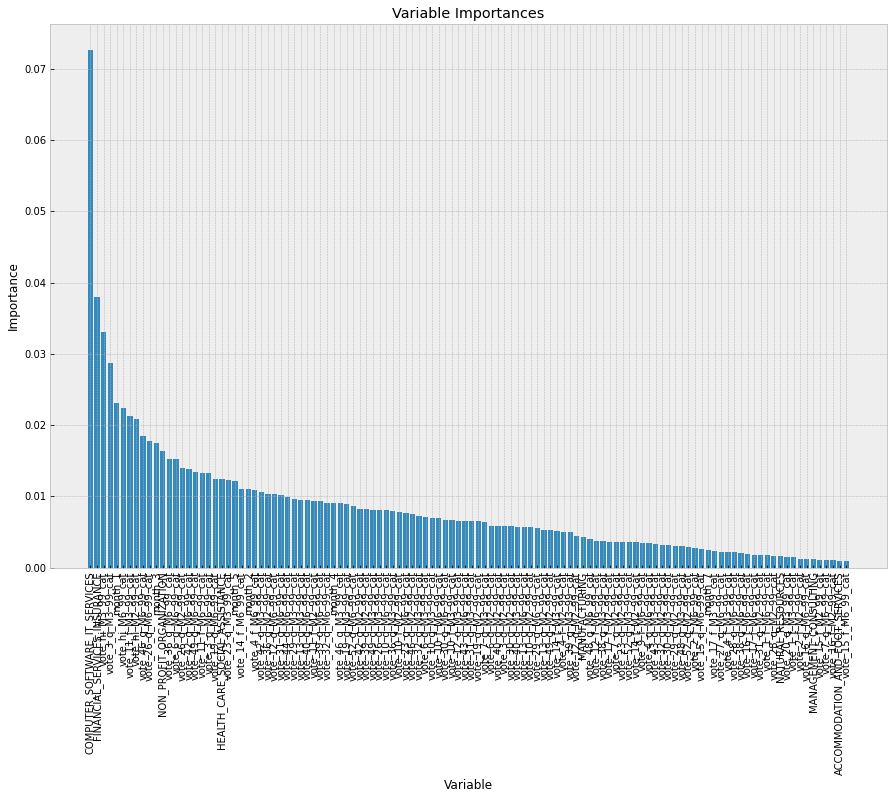

In [91]:
importances=RF.feature_importances_
feature_list = list(X_train.columns)
feature_importance= sorted(zip(importances, feature_list), reverse=True)
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
plt.style.use('bmh')

# seleccionamos las variables con importancia > 0.0005
df_imp=df[df['importance']>0.001]
x_values = list(range(len(df_imp['importance'])))
plt.figure(figsize=(15,10))
plt.bar(x_values, df_imp['importance'], orientation = 'vertical')
plt.xticks(x_values, df_imp['feature'], rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [93]:
df_imp.tail(50)

,importance,feature
66,0.005693,vote_13_q_M6_99_cat
67,0.005683,vote_10_q_M2_99_cat
68,0.005564,vote_29_q_M6_99_cat
69,0.005337,vote_13_q_M2_99_cat
70,0.005230,vote_49_q_M2_99_cat
71,0.005092,vote_14_f_M3_99_cat
72,0.005075,vote_4_f_M2_99_cat
73,0.005026,vote_39_q_M3_99_cat
74,0.004431,vote_12_q_M2_99_cat
75,0.004372,MANUFACTURING


Creamos una lista con las variables seleccionadas y aplicamos un 'RandomizedSearchCV' sobre el 'RandomForestClassifier' para obtener el mejor modelo posible con estas variables.

In [97]:
a=list(df_imp['feature'])
X_importance=X_train[a]
X_test_importance=X_test[a]

In [62]:
tree_imp=RandomForestClassifier(random_state=42,n_jobs=-1, oob_score=True)
%time gs_imp=RandomizedSearchCV(tree_imp,parameters,cv=5,n_iter=40,scoring='neg_mean_squared_error').fit(X_importance,y_train)

CPU times: user 1min 44s, sys: 9.26 s, total: 1min 53s
Wall time: 3min 20s


In [63]:
best_tree_imp=gs_imp.best_estimator_
print('RMSE Train: {0:.4f}'.format(rmse(best_tree_imp.predict(X_importance),y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(best_tree_imp.predict(X_test_importance),y_test)))
print('Precisión Train: {0:.4f}'.format(best_tree_imp.score(X_importance,y_train)))
print('Precisión Test: {0:.4f}'.format(best_tree_imp.score(X_test_importance,y_test)))

RMSE Train: 0.4278
RMSE Test: 0.6433
Precisión Train: 0.8170
Precisión Test: 0.5862


El modelo con menos variables no mejora el inicial, por lo que nos decantaremos por utilizar el modelo con todas las variables disponibles.

## 4.3. Regresión logística

A continuación implementamos una regresión logística. De esta forma podremos determinar qué variables son significativas en la predicción con la función logit.

Como una primera aproximación, utilizamos las variables que nos han salido en el análisis de importancia de las variables en el método Random Forest.

In [98]:
x_new=X_train[a]

In [99]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,x_new)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.619594
         Iterations 6
                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.106     
Dependent Variable:       vote_stress_cat      AIC:                  2100.6942 
Date:                     2020-07-18 14:18     BIC:                  2717.6448 
No. Observations:         1508                 Log-Likelihood:       -934.35   
Df Model:                 115                  LL-Null:              -1045.2   
Df Residuals:             1392                 LLR p-value:          8.9388e-09
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           6.0000                                               
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------

En el ajuste se observa como hay muchas variables cuyo coeficiente no es significativo (P>|z| > 0.05).

**Modelo 1**

Buscamos combinación de variables que cumplan con la significancia estadística en la regresión logística.

In [106]:
vars_modelo1=['COMPUTER_SOFTWARE_IT_SERVICES', 'vote_hi_M3_99_cat', 'FINANCIAL_SERVICES_INSURANCE',
          'month_3', 'NATURAL_RESOURCES', 'vote_26_q_M6_99_cat', 'vote_17_f_M2_99_cat',
          'vote_44_q_M6_99_cat', 'vote_16_q_M6_99_cat']

x_new_vars1=X_train[vars_modelo1]
x_t_new_vars1=X_test[vars_modelo1]
logit_model=sm.Logit(y_train,x_new_vars1)
result1=logit_model.fit()
print(result1.summary2())

Optimization terminated successfully.
         Current function value: 0.663812
         Iterations 5
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.042     
Dependent Variable:     vote_stress_cat      AIC:                  2020.0572 
Date:                   2020-07-18 14:21     BIC:                  2067.9241 
No. Observations:       1508                 Log-Likelihood:       -1001.0   
Df Model:               8                    LL-Null:              -1045.2   
Df Residuals:           1499                 LLR p-value:          9.7814e-16
Converged:              1.0000               Scale:                1.0000    
No. Iterations:         5.0000                                               
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------

En este primer modelo encontramos una combinación de variables con una precisión de 0.6157

Las variables que entran en la regresión son:

COMPUTER_SOFTWARE_IT_SERVICES*

vote_hi_M3_99_cat

FINANCIAL_SERVICES_INSURANCE

month_3*

NATURAL_RESOURCES

vote_26_q_M6_99_cat

vote_17_f_M2_99_cat*

vote_44_q_M6_99_cat

vote_16_q_M6_99_cat

El resultado de la regresión nos da coeficientes negativos para COMPUTER_SOFTWARE_IT_SERVICES, month_3, vote_17_f_M2_1_cat, lo cual significa que el efecto de estas variables es inverso al resto, es decir, que si la variable vale 1, disminuyen las probabilidades de tener estrés.

La relación entre las variables de voto y las preguntas asociadas son:

In [82]:
questions.query('questionNumber== [26,44,16] | factorNumber==17')

,questionNumber,factorNumber,questionTitle,factorName
16,16,6,I trust that the people I work with are committed to do a good job,Confidence
26,26,9,Do you have the tools and resources you need to do your job?,Environment
44,44,15,The business goals and strategies set by senior leadership are taking *|COMPANY_NAME|* in the right direction.,Trust & Vision
48,48,17,I see how I can advance in my career at *|COMPANY_NAME|*,Mastery
49,49,17,My job at *|COMPANY_NAME|* enables me to learn and develop new skills,Mastery
50,50,17,My manager (or someone in management) encourages and supports my development,Mastery
51,51,17,I would rate the way *|COMPANY_NAME|* uses my strengths and abilities as:,Mastery


Aplicamos la regresión logística de sklearn con las variables seleccionadas y calculamos el valor de RMSE y la precisión de train y test.

In [68]:
from sklearn.linear_model import LogisticRegression
logreg1 = LogisticRegression()
logreg1.fit(x_new_vars1, y_train)
y_pred1 = logreg1.predict(x_t_new_vars1)
print('RMSE Train: {0:.4f}'.format(rmse(logreg1.predict(x_new_vars1),y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(y_pred1,y_test)))
print('Precisión Train: {0:.4f}'.format(logreg1.score(x_new_vars1,y_train)))
print('Precisión Test: {0:.4f}'.format(logreg1.score(x_t_new_vars1,y_test)))

RMSE Train: 0.6355
RMSE Test: 0.6202
Precisión Train: 0.5962
Precisión Test: 0.6154


**Modelo 2**

Probamos otra combinación de variables para ver si tenemos mejor ajuste.

In [69]:
vars_modelo2=['COMPUTER_SOFTWARE_IT_SERVICES', 'FINANCIAL_SERVICES_INSURANCE','month_1', 
          'month_3', 'vote_hi_M6_99_cat','vote_26_q_M6_99_cat',
          'vote_44_q_M6_99_cat','NON_PROFIT_ORGANIZATION']
x_new_vars2=X_train[vars_modelo2]
x_t_new_vars2=X_test[vars_modelo2]
logit_model=sm.Logit(y_train,x_new_vars2)
result2=logit_model.fit()
print(result2.summary2())

Optimization terminated successfully.
         Current function value: 0.665943
         Iterations 5
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.039     
Dependent Variable:     vote_stress_cat      AIC:                  2024.4846 
Date:                   2020-07-18 12:48     BIC:                  2067.0329 
No. Observations:       1508                 Log-Likelihood:       -1004.2   
Df Model:               7                    LL-Null:              -1045.2   
Df Residuals:           1500                 LLR p-value:          5.4302e-15
Converged:              1.0000               Scale:                1.0000    
No. Iterations:         5.0000                                               
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------

En este caso tenemos otra combinación muy similar a la del modelo 1 pero con alguna otra variable que hace que los coeficientes sean ligeramente diferentes. La combinación es la siguiente:

COMPUTER_SOFTWARE_IT_SERVICES*

FINANCIAL_SERVICES_INSURANCE

month_1

month_3*

vote_hi_M6_99_cat

vote_26_q_M6_99_cat

vote_44_q_M6_99_cat

NON_PROFIT_ORGANIZATION*

*coeficientes negativos

La relación de las variables 'vote' con las preguntas es la siguiente:

In [70]:
questions.query('questionNumber== [26,44,42]')

,questionNumber,factorNumber,questionTitle,factorName
26,26,9,Do you have the tools and resources you need to do your job?,Environment
42,42,15,The vision and purpose of *|COMPANY_NAME|* inspires me.,Trust & Vision
44,44,15,The business goals and strategies set by senior leadership are taking *|COMPANY_NAME|* in the right direction.,Trust & Vision


Aplicamos la regresión logística de sklearn con las variables seleccionadas y calculamos el valor de RMSE y la precisión de train y test.

In [71]:
from sklearn.linear_model import LogisticRegression
logreg2 = LogisticRegression()
logreg2.fit(x_new_vars2, y_train)
y_pred2 = logreg2.predict(x_t_new_vars2)
print('RMSE Train: {0:.4f}'.format(rmse(logreg2.predict(x_new_vars2),y_train)))
print('RMSE Test: {0:.4f}'.format(rmse(y_pred2,y_test)))
print('Precisión Train: {0:.4f}'.format(logreg2.score(x_new_vars2,y_train)))
print('Precisión Test: {0:.4f}'.format(logreg2.score(x_t_new_vars2,y_test)))

RMSE Train: 0.6318
RMSE Test: 0.6223
Precisión Train: 0.6008
Precisión Test: 0.6127


Como vemos, el modelo 1 es ligeramente peor que el modelo 2.

Por último, los modelos de regresión logística nos permiten ver el peso de cada variable sobre el modelo final. Esto nos indica cuanta importancia tiene cada variable sobre la predicción final.

In [80]:
# 1. Calculamos desviación estandar de las variables
a1=np.array(np.std(x_new_vars1))
# 2. Obtenemos los coeficientes
b1=logreg1.coef_[0]
# 3. Estandarizamos los coeficientes
b_est1=b1/a1
# 4. Calculamos los pesos
pesos1=abs(b_est1/abs(b_est1).sum())*100
# 5. Creamos un dataframe para poder representarlos mejor.
df_modelo1=pd.DataFrame({'variable':vars_modelo1,
                        'coeficiente':b1,
                        'peso':pesos1})
df_modelo1.sort_values(by='peso',ascending=False)

,variable,coeficiente,peso
4,NATURAL_RESOURCES,0.858975,33.118683
8,vote_16_q_M6_99_cat,0.682969,19.664743
1,vote_hi_M3_99_cat,0.714108,11.355683
7,vote_44_q_M6_99_cat,0.508957,10.548491
6,vote_17_f_M2_99_cat,-0.392155,6.504102
2,FINANCIAL_SERVICES_INSURANCE,0.466985,6.414983
3,month_3,-0.397812,5.650449
0,COMPUTER_SOFTWARE_IT_SERVICES,-0.351111,3.768846
5,vote_26_q_M6_99_cat,0.279600,2.974019


A continuación realizamos el mismo tratamiento para el modelo 2.

In [81]:
# 1. Calculamos desviación estandar de las variables
a2=np.array(np.std(x_new_vars2))
# 2. Obtenemos los coeficientes
b2=logreg2.coef_[0]
# 3. Estandarizamos los coeficientes
b_est2=b2/a2
# 4. Calculamos los pesos
pesos2=abs(b_est2/abs(b_est2).sum())*100
# 5. Creamos un dataframe para poder representarlos mejor.
df_modelo2=pd.DataFrame({'variable':vars_modelo2,
                        'coeficiente':b_est2,
                        'peso':pesos2})
df_modelo2.sort_values(by='peso',ascending=False)

,variable,coeficiente,peso
7,NON_PROFIT_ORGANIZATION,-2.422236,20.432168
4,vote_hi_M6_99_cat,2.189340,18.467629
6,vote_44_q_M6_99_cat,2.081243,17.555804
2,month_1,1.742483,14.698279
1,FINANCIAL_SERVICES_INSURANCE,0.953691,8.044624
0,COMPUTER_SOFTWARE_IT_SERVICES,-0.912814,7.699813
3,month_3,-0.899206,7.585028
5,vote_26_q_M6_99_cat,0.654000,5.516654


In [74]:
questions.query('questionNumber== [26,44]')

,questionNumber,factorNumber,questionTitle,factorName
26,26,9,Do you have the tools and resources you need to do your job?,Environment
44,44,15,The business goals and strategies set by senior leadership are taking *|COMPANY_NAME|* in the right direction.,Trust & Vision


Calculamos matrices de confusión y clasificatio_report para cada modelo.

**Modelo 1**

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred1)

array([[138,  55],
       [ 90,  94]])

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.61      0.72      0.66       193
           1       0.63      0.51      0.56       184

    accuracy                           0.62       377
   macro avg       0.62      0.61      0.61       377
weighted avg       0.62      0.62      0.61       377



**Modelo 2**

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred2)

array([[130,  63],
       [ 83, 101]])

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       193
           1       0.62      0.55      0.58       184

    accuracy                           0.61       377
   macro avg       0.61      0.61      0.61       377
weighted avg       0.61      0.61      0.61       377

